<a href="https://colab.research.google.com/github/MoyoMbongeni/ML/blob/main/ECG_Auto_Noise_Detection_And_Severity_Ranking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Level 1.1: Online Data Fetching and Resampling

In [1]:
!pip install wfdb
import wfdb
import numpy as np
from scipy import signal

def fetch_and_resample(record_id, db_name, target_fs=360):
    """
    Fetches data directly from PhysioNet online repositories.
    Standardizes frequency to 360 Hz.
    - record_id: e.g., '100' or '118e00'
    - db_name: 'mitdb' for clean, 'nstdb' for noisy
    """
    # Stream record directly from PhysioNet using pb_dir
    # pn_dir format: 'database_name'
    record = wfdb.rdrecord(record_id, pn_dir=db_name)

    # Extract the primary signal (Lead II is usually index 0)
    raw_signal = record.p_signal[:, 0]
    original_fs = record.fs

    # Calculate resampling ratio to reach exactly 360 Hz
    if original_fs != target_fs:
        num_samples = int(len(raw_signal) * target_fs / original_fs)
        resampled_signal = signal.resample(raw_signal, num_samples)
    else:
        resampled_signal = raw_signal

    return resampled_signal, target_fs

# Usage:
# clean_raw, _ = fetch_and_resample('100', 'mitdb')
# noisy_raw, _ = fetch_and_resample('118e00', 'nstdb')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 50.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


Level 1.2: Segmentation into 5-Second Windows

In [2]:
def segment_signal(ecg_signal, fs=360, window_seconds=5):
    """
    Divides the long continuous signal into fixed 5-second windows.
    No cleaning or filtering is performed here.
    """
    samples_per_window = fs * window_seconds
    num_segments = len(ecg_signal) // samples_per_window

    # Only keep data that fits perfectly into windows
    truncated_signal = ecg_signal[:num_segments * samples_per_window]
    segments = np.split(truncated_signal, num_segments)

    return np.array(segments)

# Usage:
# clean_segments = segment_signal(clean_raw)

Level 1.3: Individual Segment Normalization (Min-Max)

In [3]:
from sklearn.preprocessing import MinMaxScaler

def normalize_segments(segments):
    """
    Normalizes each 5-second segment individually.
    Scales amplitude to 0-1 range (Min-Max Scaling).
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_list = []

    for seg in segments:
        # Reshape to (samples, 1) for the scaler, then back to 1D
        seg_norm = scaler.fit_transform(seg.reshape(-1, 1)).flatten()
        normalized_list.append(seg_norm)

    return np.array(normalized_list)

# Usage:
# clean_ready = normalize_segments(clean_segments)

Level 1.4: Visualization (Online vs. Preprocessed)

In [4]:
import matplotlib.pyplot as plt

def visualize_comparison(raw_data, processed_segment, label):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

    # Raw signal from online source (first 5 seconds)
    ax1.plot(raw_data[:1800], color='blue', alpha=0.7)
    ax1.set_title(f"Raw Signal from PhysioNet ({label})")
    ax1.set_ylabel("Amplitude")

    # Processed window (360Hz, 0-1 Scaled)
    ax2.plot(processed_segment, color='green')
    ax2.set_title(f"Preprocessed Segment (5s, 360Hz, 0-1 Scaled): {label}")
    ax2.set_ylabel("Normalized Value")

    plt.tight_layout()
    plt.show()

# Usage:
# visualize_comparison(clean_raw, clean_ready[0], "MIT-BIH Clean Record 100")

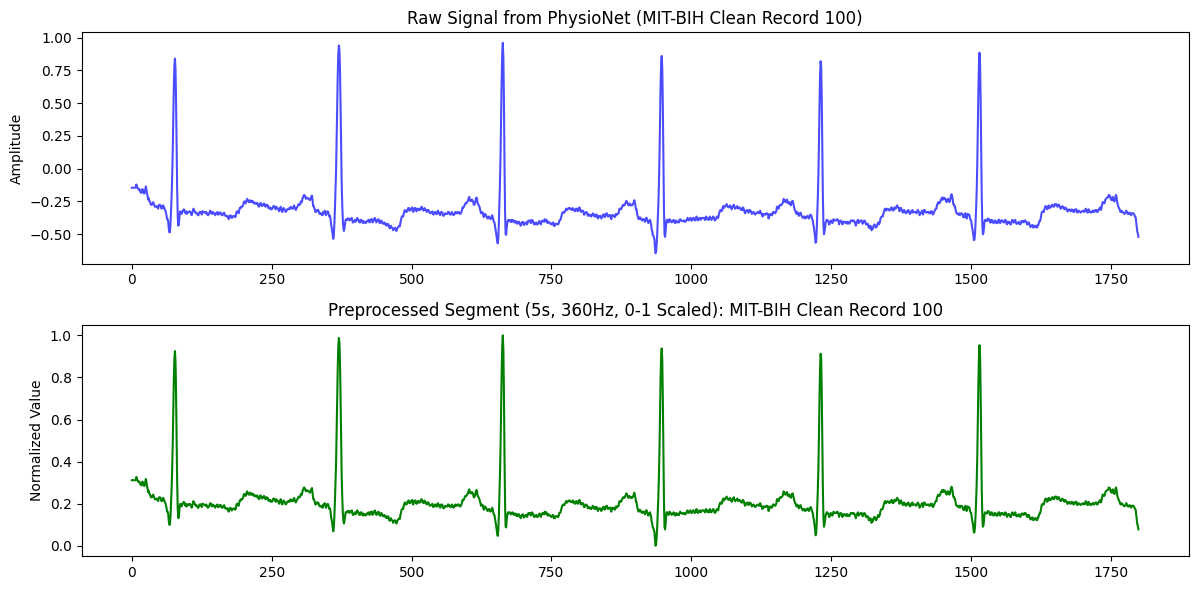

In [5]:
# 1. Fetch a record (MIT-BIH 100 is a clean record)
clean_raw, fs = fetch_and_resample('100', 'mitdb')

# 2. Segment it into 5-second blocks
clean_segments = segment_signal(clean_raw)

# 3. Normalize the segments to 0-1 range
clean_ready = normalize_segments(clean_segments)

# 4. NOW CALL the visualization function from Level 1.4
# We pass the first 5 seconds of raw data and the first processed segment
visualize_comparison(clean_raw, clean_ready[0], "MIT-BIH Clean Record 100")

Level 2.1: Method 1 - Discrete Wavelet Transform (DWT)

In [6]:
import pywt

def extract_dwt_features(segment, wavelet='db4', level=4):
    """
    Decomposes the 5s segment into frequency sub-bands.
    Extracts Energy and Std Dev from each band.
    """
    coeffs = pywt.wavedec(segment, wavelet, level=level)
    features = []

    for coeff in coeffs:
        # Energy: The sum of squares of the coefficients
        energy = np.sum(np.square(coeff))
        # Statistical variability of the band
        std_dev = np.std(coeff)

        features.extend([energy, std_dev])

    return np.array(features)

# Each segment now becomes a small vector of numbers instead of 1800 samples.

Level 2.2: Method 2 - TERMA (Two Event-Related Moving Averages)

In [7]:
def extract_terma_features(segment, fs=360):
    """
    Implements TERMA to distinguish QRS from noise.
    Uses the difference between a fast and slow moving average.
    """
    # 1. Square the signal to highlight spikes
    squared_sig = np.square(segment)

    # 2. Calculate Moving Averages (MA)
    # Windows: Short (~120ms) and Long (~600ms)
    w_short = int(0.12 * fs)
    w_long = int(0.60 * fs)

    ma_short = np.convolve(squared_sig, np.ones(w_short)/w_short, mode='same')
    ma_long = np.convolve(squared_sig, np.ones(w_long)/w_long, mode='same')

    # 3. The "TERMA Signal" is the difference
    terma_sig = ma_short - ma_long

    # 4. Extract attributes: Peak amplitude and Complexity (std)
    peak_val = np.max(terma_sig)
    complexity = np.std(terma_sig)

    return np.array([peak_val, complexity])

Level 2.3: Feature Fusion and **Labeling**

In [8]:
import numpy as np
import pandas as pd

def fuse_features_and_label(segments, label_value):
    """
    Fuses DWT and TERMA features into a single matrix and assigns a label.
    - segments: The 5s normalized ECG windows.
    - label_value: The integer ID for the noise class.
    """
    features_list = []

    for seg in segments:
        # 1. Feature Extraction (Method 1: DWT)
        dwt_feat = extract_dwt_features(seg) # Energy & Std Dev [cite: 14, 15]

        # 2. Feature Extraction (Method 2: TERMA)
        terma_feat = extract_terma_features(seg) # Peak & Complexity [cite: 16, 18]

        # 3. Fusion: Combine both methods into one vector
        combined_vector = np.hstack([dwt_feat, terma_feat])
        features_list.append(combined_vector)

    # Convert to numpy array for the SVM
    X_fused = np.array(features_list)

    # 4. Labeling: Create the target vector (y) for this class
    y_labels = np.full((X_fused.shape[0],), label_value)

    return X_fused, y_labels

# This synchronized function ensures that every record has a 'clue' (features)
# and an 'answer' (label) for the SVM to learn from.

Level 2.3.1: Data Acquisition and Class Organization

In [9]:
# 1. Fetch and process Clean signals (Class 0)
raw_clean, _ = fetch_and_resample('100', 'mitdb')
clean_segs = segment_signal(raw_clean)
# As per plan, normalize to 0-1 range
clean_segs_norm = normalize_segments(clean_segs)

# 2. Fetch and process Baseline Wander (Class 1)
raw_bw, _ = fetch_and_resample('bw', 'nstdb')
bw_segs = segment_signal(raw_bw)
bw_segs_norm = normalize_segments(bw_segs)

# 3. Fetch and process Muscle Artifact (Class 2)
raw_ma, _ = fetch_and_resample('ma', 'nstdb')
ma_segs = segment_signal(raw_ma)
ma_segs_norm = normalize_segments(ma_segs)

# 4. Fetch and process EMG / Powerline Interference (Class 3)
raw_emg, _ = fetch_and_resample('em', 'nstdb')
emg_segs = segment_signal(raw_emg)
emg_segs_norm = normalize_segments(emg_segs)

print("Data successfully fetched, segmented, and normalized for all 4 classes.")

Data successfully fetched, segmented, and normalized for all 4 classes.


Level 2.3.2: Applying Fusion and Final Dataset Construction

In [10]:
import numpy as np

# 1. Apply the fusion function to each class
# Class 0: Clean
X_clean, y_clean = fuse_features_and_label(clean_segs_norm, 0)

# Class 1: Baseline Wander (BW)
X_bw, y_bw = fuse_features_and_label(bw_segs_norm, 1)

# Class 2: Muscle Artifact (MA)
X_ma, y_ma = fuse_features_and_label(ma_segs_norm, 2)

# Class 3: EMG / Powerline
X_emg, y_emg = fuse_features_and_label(emg_segs_norm, 3)

# 2. Combine all classes into a single training dataset
# This creates the final matrix where each row is a record and each column is a feature
X_svm_final = np.vstack([X_clean, X_bw, X_ma, X_emg])
y_svm_final = np.concatenate([y_clean, y_bw, y_ma, y_emg])

print("--- SVM Feature Matrix Assembly Complete ---")
print(f"Total records for SVM: {X_svm_final.shape[0]}")
print(f"Number of features (Dimensions): {X_svm_final.shape[1]}") # Expecting 12

--- SVM Feature Matrix Assembly Complete ---
Total records for SVM: 1444
Number of features (Dimensions): 12


Level 2.4: SVM Training and Performance Evaluation

In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score, classification_report

# 1. Split the data into Training (80%) and Testing (20%) sets
# We use 'stratify' to ensure each noise class is represented equally in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X_svm_final, y_svm_final, test_size=0.2, random_state=42, stratify=y_svm_final
)

# 2. Feature Scaling
# SVM is sensitive to the scale of features (DWT energy vs TERMA peaks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Train the SVM with RBF Kernel [cite: 21, 50]
# probability=True allows us to calculate the AUC metric later
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# 4. Generate Predictions
y_pred = svm_model.predict(X_test_scaled)
y_proba = svm_model.predict_proba(X_test_scaled)

# 5. Calculate Evaluation Metrics [cite: 25, 52, 54]
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba, multi_class='ovr')

print("--- SVM Training Results ---")
print(f"F1-Score: {f1:.4f}")
print(f"MCC:      {mcc:.4f}")
print(f"AUC:      {auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred,
      target_names=['Clean', 'BW', 'MA', 'EMG']))

--- SVM Training Results ---
F1-Score: 0.9827
MCC:      0.9770
AUC:      0.9994

Classification Report:
               precision    recall  f1-score   support

       Clean       1.00      1.00      1.00        72
          BW       0.97      0.99      0.98        72
          MA       0.99      0.96      0.97        73
         EMG       0.97      0.99      0.98        72

    accuracy                           0.98       289
   macro avg       0.98      0.98      0.98       289
weighted avg       0.98      0.98      0.98       289



Level 2.5: Severity Ranking Module (SVM Branch)

In [12]:
def get_svm_severity_rank(features, predicted_class):
    """
    Ranks the severity of the detected noise.
    Rank 0: Clean
    Rank 1: Low Severity
    Rank 2: Medium Severity
    Rank 3: High/Severe
    """
    if predicted_class == 0:
        return 0 # Clean signals are always Rank 0

    # We use DWT Energy (Feature index 0-9) and TERMA Complexity (Index 11)
    # High energy/complexity relative to the norm indicates higher severity. [cite: 15, 44, 47]
    energy_score = features[0] # Using the first DWT sub-band energy as a proxy
    complexity_score = features[11] # TERMA complexity [cite: 18, 47]

    # Combined metric for ranking
    severity_metric = energy_score + (complexity_score * 10)

    if severity_metric < 0.2:
        return 1
    elif severity_metric < 0.5:
        return 2
    else:
        return 3

# Testing the ranking on our Test Set
test_sample_idx = 0
sample_features = X_test[test_sample_idx]
sample_pred = y_pred[test_sample_idx]

rank = get_svm_severity_rank(sample_features, sample_pred)

print(f"--- SVM Severity Analysis ---")
print(f"Detected Noise Class: {sample_pred} (0:Clean, 1:BW, 2:MA, 3:EMG)")
print(f"Assigned Severity Rank: {rank}")

--- SVM Severity Analysis ---
Detected Noise Class: 0 (0:Clean, 1:BW, 2:MA, 3:EMG)
Assigned Severity Rank: 0


Level 3.0: Corrected Data Generation (Fixing the 404 Error)

In [13]:
import numpy as np

def generate_labeled_data():
    """
    Fetches Clean, BW, MA, and EMG signals directly from PhysioNet.
    Syncs with Level 2.3 requirements for labeling.
    """
    # Actual record names on PhysioNet servers
    # Format: (Record_ID, Database_Name, Label_Index)
    records_config = [
        ('100', 'mitdb', 0), # Clean [cite: 5, 33]
        ('bw', 'nstdb', 1),  # Baseline Wander
        ('ma', 'nstdb', 2),  # Muscle Artifact
        ('em', 'nstdb', 3)   # EMG / Powerline
    ]

    all_segs, all_labs, all_sevs = [], [], []

    for rec_id, db, label in records_config:
        try:
            # 1. Fetch & Resample to 360Hz [cite: 12, 41]
            raw, _ = fetch_and_resample(rec_id, db)
            # 2. Segment into 5s windows [cite: 10, 39]
            segs = segment_signal(raw)
            # 3. Normalize to 0-1 range [cite: 11, 40]
            norm_segs = normalize_segments(segs)

            for s in norm_segs:
                all_segs.append(s)
                all_labs.append(label)
                # Severity Ranking Logic (Rank 0-3)
                # Clean is Rank 0. For noise, we use signal variance as a proxy for severity.
                if label == 0:
                    all_sevs.append(0)
                else:
                    std_val = np.std(s)
                    rank = 1 if std_val < 0.1 else (2 if std_val < 0.2 else 3)
                    all_sevs.append(rank)
        except Exception as e:
            print(f"Error fetching {rec_id} from {db}: {e}")

    return np.array(all_segs), np.array(all_labs), np.array(all_sevs)

# Now instantiate the data globally to avoid NameErrors later
all_segments, all_labels, all_severity = generate_labeled_data()
print(f"Data ready! Total segments: {len(all_segments)}")

Data ready! Total segments: 1444


Level 3.1: 1D-CNN Architecture and Training (Non-Feature-Based)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

# 1. Prepare data for CNN (Shape: [Samples, Time_Steps, Channels])
# The CNN needs 3D input: (Records, 1800 samples, 1 channel)
X_cnn = all_segments.reshape(all_segments.shape[0], 1800, 1)

# Split for CNN (80% Training, 20% Testing) [cite: 23, 52]
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_cnn, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

# 2. Build the Model Architecture
cnn_model = Sequential([
    # Automatically extracts spatial patterns from the raw signal
    Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(1800, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5), # Regularization [cite: 28, 56]
    Dense(4, activation='softmax') # 4 classes: Clean, BW, MA, EMG
])

# 3. Compile and Train
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = cnn_model.fit(X_train_c, y_train_c, epochs=10, validation_split=0.1, verbose=1)

print("CNN Training Complete.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - accuracy: 0.3114 - loss: 1.3625 - val_accuracy: 0.6121 - val_loss: 0.8927
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5529 - loss: 0.9137 - val_accuracy: 0.7759 - val_loss: 0.6331
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6920 - loss: 0.7249 - val_accuracy: 0.8534 - val_loss: 0.4945
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7552 - loss: 0.6188 - val_accuracy: 0.8448 - val_loss: 0.4296
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8088 - loss: 0.4920 - val_accuracy: 0.9224 - val_loss: 0.3968
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8223 - loss: 0.4650 - val_accuracy: 0.8793 - val_loss: 0.3918
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8562 - loss: 0.4034 - val_accuracy: 0.8879 - val_loss: 0.3561
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8379 - loss: 0.4295 - val_accuracy: 0.8793 - v

Level 3.2: CNN Evaluation (AUC, F1, MCC)

In [15]:
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score

# 1. Predictions
y_proba_cnn = cnn_model.predict(X_test_c)
y_pred_cnn = np.argmax(y_proba_cnn, axis=1)

# 2. Metrics
f1_cnn = f1_score(y_test_c, y_pred_cnn, average='weighted')
mcc_cnn = matthews_corrcoef(y_test_c, y_pred_cnn)
auc_cnn = roc_auc_score(y_test_c, y_proba_cnn, multi_class='ovr')

print(f"--- CNN Results ---")
print(f"F1-Score: {f1_cnn:.4f}")
print(f"MCC:      {mcc_cnn:.4f}")
print(f"AUC:      {auc_cnn:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
--- CNN Results ---
F1-Score: 0.9102
MCC:      0.8810
AUC:      0.9822


Level 3.3: CNN Severity Ranking Logic

In [21]:
def get_cnn_severity_ranking(model, raw_segment):
    """
    Calculates the extent of noise in a signal using the CNN's confidence
    and the Signal Variance.
    """
    # 1. Get the Model's confidence
    # Reshape segment for CNN input: (1, 1800, 1)
    prediction_proba = model.predict(raw_segment.reshape(1, 1800, 1), verbose=0)[0]
    predicted_class = np.argmax(prediction_proba)
    confidence = np.max(prediction_proba)

    # 2. Measure the 'Extent' of the noise
    # We calculate the Standard Deviation of the segment.
    # High variance in a noisy class = High Severity.
    signal_variance = np.std(raw_segment)

    if predicted_class == 0: # Clean
        return "Rank 0 (Clean)", predicted_class

    # 3. Ranking Logic (Combining model confidence + signal variance)
    # Severity Score = (Confidence * 0.4) + (Signal Variance * 0.6)
    # We scale variance so that ~0.3 is 'High'
    severity_score = (confidence * 0.4) + (min(signal_variance, 0.4) / 0.4 * 0.6)

    if severity_score < 0.4:
        rank = "Rank 1 (Low)"
    elif severity_score < 0.7:
        rank = "Rank 2 (Medium)"
    else:
        rank = "Rank 3 (High)"

    return rank, predicted_class

# Test the ranking on a single test signal
sample_sig = X_test_c[0]
rank_label, noise_type = get_cnn_severity_ranking(cnn_model, sample_sig)

print(f"--- CNN Severity Ranking Test ---")
print(f"Predicted Noise Type: {noise_type}")
print(f"Noise Extent Ranking: {rank_label}")

--- CNN Severity Ranking Test ---
Predicted Noise Type: 0
Noise Extent Ranking: Rank 0 (Clean)


The Hybrid Gatekeeper: Validation, Fixing, and Testing

In [31]:
def validate_and_process_signal(csv_path):
    try:
        # Load data
        df = pd.read_csv(csv_path, header=None)
        raw_signal = df.values.flatten()

        # 1. Fix Length
        if len(raw_signal) != 1800:
            if len(raw_signal) > 1800:
                processed_signal = raw_signal[:1800]
            else:
                processed_signal = np.pad(raw_signal, (0, 1800 - len(raw_signal)), 'edge')
        else:
            processed_signal = raw_signal

        # 2. Normalize (Min-Max)
        processed_signal = (processed_signal - np.min(processed_signal)) / (np.max(processed_signal) - np.min(processed_signal) + 1e-8)

        # 3. ROUTE TO MODELS (The Fix is here: passing processed_signal)
        return run_final_inference(processed_signal)

    except Exception as e:
        # Returning a dictionary even on error to prevent the TypeError
        return {"Status": "Error", "Message": str(e)}

def run_final_inference(clean_input):
    """
    The actual testing stage using the correct Level 2.3 function.
    """
    # 1. Branch A: SVM Path
    # We use 'fuse_features_and_label' which you defined earlier.
    # We pass [clean_input] as a list because the function expects a collection of segments.
    svm_features, _ = fuse_features_and_label([clean_input], label_value=0)

    # Scale the features
    svm_feat_scaled = scaler.transform(svm_features)
    svm_class = svm_model.predict(svm_feat_scaled)[0]

    # 2. Branch B: CNN Path
    cnn_in = clean_input.reshape(1, 1800, 1)
    cnn_prob = cnn_model.predict(cnn_in, verbose=0)[0]
    cnn_class = np.argmax(cnn_prob)

    # 3. Severity Ranking (Using the confidence-based CNN rank)
    rank_label, _ = get_cnn_severity_ranking(cnn_model, clean_input)

    return {
        "Status": "Success",
        "SVM_Detection": svm_class,
        "CNN_Detection": cnn_class,
        "Rank": rank_label,
        "Confidence": f"{np.max(cnn_prob)*100:.2f}%"
    }
